In [1]:
import numpy as np
import pandas as pd

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.
/Users/naoki/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/naoki/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/naoki/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/naoki/opt/anaconda3/lib/python3.7/sit

In [3]:
# X_train = X_train.reshape(-1, 784)
# X_test = X_test.reshape(-1, 784)
X_train = X_train/255.0
X_test = X_test/255.0
X_test.shape

(10000, 28, 28)

In [4]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) 
print(y_test_one_hot.shape)

(60000,)
(60000, 10)
float64
(10000, 10)


In [5]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [6]:
get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=20)
for mini_X_train, mini_y_train in get_mini_batch:
    mini_X_train, mini_y_train

In [7]:
mini_X_train = mini_X_train.reshape(20, 1, 28, 28)


 # 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。

フォワードプロパゲーションの数式は以下のようになります。

In [8]:
class SimpleInitializer:

    
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
        
    def W(self,filta_num, Chanel, filta_size_h, filta_size_w):
        np.random.seed(0)
        self.W = self.sigma * np.random.randn(filta_num, Chanel, filta_size_h, filta_size_w)
        return self.W
    
    
    def B(self, filta_num):
        np.random.seed(0)
        self.B = self.sigma * np.random.randn(filta_num,1)
        return self.B

In [9]:
class XavierInitializer:
    
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
        
    
    def W(self,filta_num, Chanel, filta_size_h, filta_size_w):
        self.sigma = (1 / np.sqrt(filta_num))
        np.random.seed(0)
        self.W = self.sigma * np.random.randn(filta_num, Chanel, filta_size_h, filta_size_w)
        return self.W
        
    def B(self,filta_num):
        np.random.seed(0)
        self.sigma = (1 / np.sqrt(filta_num))
        self.B = self.sigma * np.random.randn(filta_num,1)
        return self.B

In [10]:
class He:
    
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
    
    def W(self, filta_num, Chanel, filta_size_h, filta_size_w):
        sigma = np.sqrt(2 / 1)
        np.random.seed(0)
        self.W = sigma * np.random.randn(filta_num, Chanel, filta_size_h, filta_size_w)
        return self.W
        
    def B(self,filta_num):
        sigma = np.sqrt(2 / 1)
        np.random.seed(0)
        self.B = sigma * np.random.randn(filta_num,1)
        return self.B

In [11]:
X_train.shape

(60000, 28, 28)

In [12]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.001):
        self.lr = lr
        
    def update(self,layer):  #, W,B,dW,dB
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= (self.lr * layer.dW)
        layer.B -= (self.lr * layer.dB)
        return layer.W, layer.B

 # 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

In [13]:
def height_out(X_height,pad_n,Filta_height,stride):
    out_h = (X_height + 2*pad_n - Filta_height)//stride + 1
    return out_h

In [14]:
def width_out(X_width,pad_n,Filta_width,stride):
    out_w = (X_width + 2*pad_n - Filta_width)//stride + 1
    return out_w

In [15]:
height_out(mini_X_train.shape[2],0,3,1)

26

In [16]:
width_out(mini_X_train.shape[3],0,3,1)

26

In [17]:
mini_X_train.shape[1]

1

In [18]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = height_out(X_height=H,pad_n=pad, Filta_height=filter_h, stride=stride)
    out_w = width_out(X_width=W,pad_n=pad, Filta_width=filter_w, stride=stride)
#     (H + 2*pad - filter_h)//stride + 1
#     (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [19]:
def col2im(col, X, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = X.shape
    out_h = height_out(X_height=H,pad_n=pad, Filta_height=filter_h, stride=stride)
    out_w = width_out(X_width=W,pad_n=pad, Filta_width=filter_w, stride=stride)
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [20]:
mini_X_train
C = im2col(mini_X_train, 3, 3, stride=1, pad=0)

In [21]:
mini_X_train.shape

(20, 1, 28, 28)

In [22]:
col2im(C, mini_X_train, 3, 3, stride=1, pad=0).shape

(20, 1, 28, 28)

In [23]:
X = np.arange(16).reshape([4,4])
# print(X)
F_W = 3
F_H = 3

x_hot = np.zeros([2,2,3,3])

for i in range(x_hot.shape[0]):
    for j in range(x_hot.shape[1]):
        x_hot[i,j,:,:] = X[i:i+F_W, j:j+F_H]
#             print(X[i:i+F_W, j:j+F_H])
#             print("=======")
x_hot

array([[[[ 0.,  1.,  2.],
         [ 4.,  5.,  6.],
         [ 8.,  9., 10.]],

        [[ 1.,  2.,  3.],
         [ 5.,  6.,  7.],
         [ 9., 10., 11.]]],


       [[[ 4.,  5.,  6.],
         [ 8.,  9., 10.],
         [12., 13., 14.]],

        [[ 5.,  6.,  7.],
         [ 9., 10., 11.],
         [13., 14., 15.]]]])

In [24]:
width_out(X_width=28,pad_n=1, Filta_width=2, stride=1)

29

In [25]:
class SimpleConv2d:
    def __init__(self, 
                 filta_num=1, 
                 filta_size_h=2, 
                 filta_size_w=2,
                 stride=1,
                 pad = 1,
                 initializer=XavierInitializer(), 
                 optimizer=SGD(lr=0.001)):
        

        self.filta_num = filta_num
        self.filta_size_h = filta_size_h
        self.filta_size_w = filta_size_w
        self.pad = pad
        self.stride = stride
        self.kernel  = None
        self.initializer = initializer
        self.optimizer = optimizer
        self.W = None
        self.B = None
        
#         X_height,pad_n=0,Filta_height,stride
        
        
    def im2col(self, input_data):
        N, C, H, W = input_data.shape


        out_h = height_out(X_height=H,pad_n=self.pad, Filta_height= self.filta_size_h, stride=self.stride)
        out_w = width_out(X_width=W,pad_n=self.pad, Filta_width=self.filta_size_w, stride=self.stride)
        img = np.pad(input_data, [(0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        col = np.zeros((N, C, self.filta_size_h, self.filta_size_w, out_h, out_w))

        for y in range(self.filta_size_h):
            y_max = y + self.stride*out_h
            for x in range(self.filta_size_w):
                x_max = x + self.stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col
    
    
    
    def col2im(self, col, X):
        N, C, H, W = X.shape
        out_h = height_out(X_height=H,pad_n=self.pad, Filta_height=self.filta_size_h, stride=self.stride)
        out_w = width_out(X_width=W,pad_n=self.pad, Filta_width=self.filta_size_w, stride=self.stride)
        col = col.reshape(N, out_h, out_w, C, self.filta_size_h, self.filta_size_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*self.pad + self.stride - 1, W + 2*self.pad + self.stride - 1))
        for y in range(self.filta_size_h):
            y_max = y + self.stride*out_h
            for x in range(self.filta_size_w):
                x_max = x + self.stride*out_w
                img[:, :, y:y_max:self.stride, x:x_max:self.stride] += col[:, :, y, x, :, :]
        return img[:, :, self.pad:H + self.pad, self.pad:W + self.pad]
    
        
        
            
    def forward(self,X):
        if self.W is None:
            self.W = self.initializer.W(self.filta_num, X.shape[1], self.filta_size_h , self.filta_size_w)
        if self.B is None:
            self.B = self.initializer.B(self.filta_num)
        FN, C, FH, FW = self.W.shape
        N, C, H, W = X.shape
        out_h = height_out(X_height=H,pad_n=self.pad, Filta_height=self.filta_size_h, stride=self.stride)
        out_w = width_out(X_width=W,pad_n=self.pad, Filta_width=self.filta_size_w, stride=self.stride)
            
        self.col = self.im2col(X)
        self.col_W = self.W.reshape(FN, -1).T
        out = np.dot(self.col, self.col_W) + self.B.T
        out = out.reshape(N, out_h, out_w, -1).transpose(0,3,1,2)
        self.X = X

        return out
    
    
    def backward(self,dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.dB = np.sum(dout, axis=0).reshape(self.filta_num,1)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
#         print(dcol.shape,"dcol")
        self.dx = self.col2im(dcol,self.X)
        
        return self.dx
        self = self.optimizer.update(self)

In [26]:
C2d = SimpleConv2d(filta_num=3, filta_size_h=3,  filta_size_w=3, stride=1, pad=1, initializer=SimpleInitializer())
fd = C2d.forward(mini_X_train)
print(fd.shape,"fd")
C2d.backward(fd).shape

(20, 3, 28, 28) fd


(20, 1, 28, 28)

 # 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

In [27]:
class Pooling_max:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    
        
    def im2col(self, input_data):
        N, C, H, W = input_data.shape
        out_h = height_out(X_height=H,pad_n=self.pad, Filta_height= self.pool_h, stride=self.stride)
        out_w = width_out(X_width=W,pad_n=self.pad, Filta_width=self.pool_w, stride=self.stride)


        img = np.pad(input_data, [(0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        col = np.zeros((N, C, self.pool_h, self.pool_w, out_h, out_w))

        for y in range(self.pool_h):
            y_max = y + self.stride*out_h
            for x in range(self.pool_w):
                x_max = x + self.stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col
    
    
    
    def col2im(self, col, X):
        N, C, H, W = X.shape
        out_h = height_out(X_height=H,pad_n=self.pad, Filta_height=self.pool_h, stride=self.stride)
        out_w = width_out(X_width=W,pad_n=self.pad, Filta_width=self.pool_w, stride=self.stride)
        col = col.reshape(N, out_h, out_w, C, self.pool_h, self.pool_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*self.pad + self.stride - 1, W + 2*self.pad + self.stride - 1))
        for y in range(self.pool_h):
            y_max = y + self.stride*out_h
            for x in range(self.pool_w):
                x_max = x + self.stride*out_w
                img[:, :, y:y_max:self.stride, x:x_max:self.stride] += col[:, :, y, x, :, :]
        return img[:, :, self.pad:H + self.pad, self.pad:W + self.pad]
       
        
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = height_out(X_height=H,pad_n=self.pad, Filta_height=self.pool_h, stride=self.stride)
        out_w = width_out(X_width=W,pad_n=self.pad, Filta_width=self.pool_w, stride=self.stride)

        col = self.im2col(x)     #, self.pool_h, self.pool_w, self.stride, self.pad
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self.col2im(dcol, self.x)
   
        return dx
        self = self.optimizer.update(self)

In [28]:
pool = Pooling_max( pool_h=2, pool_w=2, stride=2, pad=1)
pl = pool.forward(mini_X_train)
print(pl.shape,"pl")
pool.backward(pl).shape

(20, 1, 15, 15) pl


(20, 1, 28, 28)

 # 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。

範囲内の最大値ではなく、平均値を出力とするプーリング層です。

画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません

In [29]:
class Pooling_mean:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    
        
    def im2col(self, input_data):
        N, C, H, W = input_data.shape
        out_h = height_out(X_height=H,pad_n=self.pad, Filta_height= self.pool_h, stride=self.stride)
        out_w = width_out(X_width=W,pad_n=self.pad, Filta_width=self.pool_w, stride=self.stride)


        img = np.pad(input_data, [(0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        col = np.zeros((N, C, self.pool_h, self.pool_w, out_h, out_w))

        for y in range(self.pool_h):
            y_max = y + self.stride*out_h
            for x in range(self.pool_w):
                x_max = x + self.stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.stride, x:x_max:self.stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        return col
    
    
    
    def col2im(self, col, X):
        N, C, H, W = X.shape
        out_h = height_out(X_height=H,pad_n=self.pad, Filta_height=self.pool_h, stride=self.stride)
        out_w = width_out(X_width=W,pad_n=self.pad, Filta_width=self.pool_w, stride=self.stride)
        col = col.reshape(N, out_h, out_w, C, self.pool_h, self.pool_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*self.pad + self.stride - 1, W + 2*self.pad + self.stride - 1))
        for y in range(self.pool_h):
            y_max = y + self.stride*out_h
            for x in range(self.pool_w):
                x_max = x + self.stride*out_w
                img[:, :, y:y_max:self.stride, x:x_max:self.stride] += col[:, :, y, x, :, :]
        return img[:, :, self.pad:H + self.pad, self.pad:W + self.pad]
       
        
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = height_out(X_height=H,pad_n=self.pad, Filta_height=self.pool_h, stride=self.stride)
        out_w = width_out(X_width=W,pad_n=self.pad, Filta_width=self.pool_w, stride=self.stride)

        col = self.im2col(x)     #, self.pool_h, self.pool_w, self.stride, self.pad
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self.col2im(dcol, self.x)
   
        return dx

In [30]:
pool = Pooling_mean( pool_h=2, pool_w=2, stride=2, pad=1)
pl = pool.forward(mini_X_train)
print(pl.shape,"pl")
pool.backward(pl).shape

(20, 1, 15, 15) pl


(20, 1, 28, 28)

 # 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。

フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [31]:
class Flatten():
    def __init__(self,):
        self.X = None
        self.X_shape = None
        
    
    def forward(self, X):
        self.X_shape = X.shape
        N,C, H,W = X.shape
        Fl_X = X.reshape(N,-1)
        return Fl_X
        
        
    def backward(self, X):
        bk_FL_X = X.reshape(self.X_shape)
        return bk_FL_X

In [32]:
mini_X_train.shape
mini_X_train.reshape(-1,)

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
Fl = Flatten()
Fl.forward(mini_X_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

 # 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。

精度は低くともまずは動くことを目指してください。

In [34]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer

        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
        self.h_w = None
        self.h_b = None
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
    
    
    
    def forward(self, X,):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """   
        self.Z = X 
        self.A = self.Z @ self.W + self.B

        return self.A
        

    
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 更新
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA
        dZ = dA @ self.W.T
        
        self = self.optimizer.update(self)
        return dZ

In [35]:
class soft_max:
    
    def __init__(self):
        self.soft_max = 0
    
    def forward(self,data):
        
        if data.ndim == 2:
            data = data.T
            data = data - np.max(data, axis=0)
            self.soft_max = np.exp(data) / np.sum(np.exp(data), axis=0)
            return self.soft_max.T
        data = data - np.max(data)   # オーバーフロー対策
        self.soft_max = np.exp(data) / np.sum(np.exp(data))
        return self.soft_max

    def backward(self, target):
        self.dA = self.soft_max.T - target
        return self.dA

In [36]:
class sigmoid:
    
    
    def forward(self,data):
        C = np.max(data)
        self.sig = 1 / (1 + np.exp(-data/C))
        return self.sig
    
    
    def backward(self,dZ):
        self.sig_d = dZ * (1 - self.sig) * self.sig
        return self.sig_d

In [37]:
class tanh:
    
    
    def forward(self,data):
        C = np.max(data)
        self.t = np.tanh(data/C)
        return self.t
    
    
    def backward(self,A,dZ):
        C = np.max(A)
        B = A/C
        self.dA2 = dZ*(1-np.tanh(B))
        return self.dA2

In [38]:
class ReLU():
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        self.A = x.copy()
        self.A[self.mask] = 0
        return self.A
        
    def backward(self, dA):
        dA[self.mask] = 0
        dA = dA
        return dA

In [39]:
class SimpleInitializer_A:

    
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
        
    def W(self, n_nodes1, n_nodes2):
        np.random.seed(5)
        self.W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return self.W
    
    
    def B(self, n_nodes2):
        np.random.seed(5)
        self.B = self.sigma * np.random.randn(n_nodes2)
        return self.B

In [40]:
class He_A:
    
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
    
    def W(self,  n_node1, n_node2):
        sigma = np.sqrt(2 / n_node1)
        np.random.seed(0)
        self.W = sigma * np.random.randn(n_node1, n_node2)
        return self.W
        
    def B(self,n_node2):
        sigma = np.sqrt(2 / n_node2)
        np.random.seed(0)
        self.B = sigma * np.random.randn(n_node2)
        return self.B

In [41]:
class XavierInitializer_A:
    
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
        
    
    def W(self, n_node1, n_node2):
        self.sigma = (1 / np.sqrt(n_node1))
        np.random.seed(0)
        self.W = self.sigma * np.random.randn(n_node1, n_node2)
        return self.W
        
    def B(self,n_node2):
        np.random.seed(0)
        self.B = self.sigma * np.random.randn(n_node2)
        return self.B

In [42]:
C2d = SimpleConv2d(filta_num=3, filta_size_h=3,  filta_size_w=3, stride=1, pad=1, initializer=SimpleInitializer())
fd = C2d.forward(mini_X_train)
print(fd.shape,"fd")
C2d.backward(fd).shape

(20, 3, 28, 28) fd


(20, 1, 28, 28)

In [43]:
pool = Pooling_max( pool_h=2, pool_w=2, stride=2, pad=1)
pl = pool.forward(mini_X_train)
print(pl.shape,"pl")
pool.backward(pl).shape

(20, 1, 15, 15) pl


(20, 1, 28, 28)

In [44]:
def loss_fnk(target,pred):
    Loss = - np.sum(target * np.log(pred)) / target.shape[0]
    return Loss

In [45]:
C2d = SimpleConv2d(filta_num=3, filta_size_h=3,  filta_size_w=3, stride=1, pad=1, initializer=SimpleInitializer())
pool = Pooling_max( pool_h=2, pool_w=2, stride=2, pad=1)
Fl = Flatten()
fd = C2d.forward(mini_X_train)
Po = pool.forward(fd)
fl = Fl.forward(Po)
fl.shape

(20, 675)

In [46]:
class ScratchSimpleDNN():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, 
                 batch_size=20, 
                 epoch=20, 
                 Conv = SimpleConv2d(filta_num=3, filta_size_h=2,  filta_size_w=2, stride=1, pad=1, initializer=SimpleInitializer()),
                 Pool =  Pooling_max( pool_h=2, pool_w=2, stride=2, pad=1),
                 Flatten = Flatten(),
                 FC1 = FC(675,600,initializer=He_A(),optimizer=SGD(lr=0.01)),
                 FC2=FC(600,600,initializer=He_A(),optimizer=SGD(lr=0.01)),
                 FC3=FC(600,10,initializer=He_A(),optimizer=SGD(lr=0.01)),
                 activation_con = ReLU(),
                 activation1 = ReLU(),
                 activation2 = ReLU(),
                 activation_end = soft_max(),
                 verbose = True):
        
        
        self.verbose = verbose
        self.batch_size = batch_size
        self.Loss = 0
        self.epoch = epoch
        self.Conv = Conv
        self.Pool = Pool
        self.Flatten = Flatten
        self.FC1 = FC1
        self.FC2 = FC2
        self.FC3 = FC3
        self.activation_con = activation_con
        self.activation1 = activation1
        self.activation2 = activation2
        self.activation3 = activation_end
        
        
        
    def fit(self, data, target, test, target2):
        self.loss_list = []
        if data.ndim == 3:
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        
        if test.ndim == 3:
            test = test.reshape(test.shape[0], 1, test.shape[1], test.shape[2])
            
        for i in range(self.epoch):
            print(i,"epoch")
            get_mini_batch = GetMiniBatch(data, target, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                self.Co = self.Conv.forward(mini_X_train)
                self.Co_ac = self.activation_con.forward(self.Co)
                self.pool_max = self.Pool.forward(self.Co_ac)
                self.fl = self.Flatten.forward(self.pool_max )
                
                self.A1 = self.FC1.forward(self.fl)
                self.Z1 = self.activation1.forward(self.A1)

                self.A2 = self.FC2.forward(self.Z1)
                self.Z2 = self.activation2.forward(self.A2)

                self.A3 = self.FC3.forward(self.Z2)
                self.Z3 = self.activation3.forward(self.A3)
    
                self.A3_b = self.activation3.backward(mini_y_train)
                self.Z3_b = self.FC3.backward(self.A3_b)
                
                self.Z2_b = self.activation2.backward(self.Z3_b)
                self.A2_b = self.FC2.backward(self.Z2_b)
                
                self.Z1_b = self.activation1.backward(self.A2_b)
                self.A1_b = self.FC1.backward(self.Z1_b)
                
                self.fl_b = self.Flatten.backward(self.A1_b )
                self.pool_max_b = self.Pool.backward(self.fl_b)
                self.Co_ac_b = self.activation_con.backward(self.pool_max_b)
                self.Co_b = self.Conv.backward(self.Co_ac_b)
                
                
            
            
            Co = self.Conv.forward(test)
            Co_ac = self.activation_con.forward(Co)
            pool_max = self.Pool.forward(Co_ac)
            fl = self.Flatten.forward(pool_max )
            A1 = self.FC1.forward(fl)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            print("Z3_max",np.argmax(Z3,axis=1))
            loss= loss_fnk(target2, Z3)
            self.loss_list.append(loss)
            
            
    def predict(self, data):
        if data.ndim == 3:
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        
        Co = self.Conv.forward(data)
        Co_ac = self.activation_con.forward(Co)
        pool_max = self.Pool.forward(Co_ac)
        fl = self.Flatten.forward(pool_max )
        A1 = self.FC1.forward(fl)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        y_pred = np.argmax(Z3,axis=1)
        return y_pred

In [47]:
DNN = ScratchSimpleDNN(epoch=15)
DNN.fit(X_train, y_train_one_hot, X_test, y_test_one_hot)

0 epoch
Z3_max [7 2 1 ... 4 5 6]
1 epoch
Z3_max [7 2 1 ... 4 5 6]
2 epoch
Z3_max [7 2 1 ... 4 5 6]
3 epoch
Z3_max [7 2 1 ... 4 5 6]
4 epoch
Z3_max [7 2 1 ... 4 5 6]
5 epoch
Z3_max [7 2 1 ... 4 5 6]
6 epoch
Z3_max [7 2 1 ... 4 5 6]
7 epoch
Z3_max [7 2 1 ... 4 5 6]
8 epoch
Z3_max [7 2 1 ... 4 5 6]
9 epoch
Z3_max [7 2 1 ... 4 5 6]
10 epoch
Z3_max [7 2 1 ... 4 5 6]
11 epoch
Z3_max [7 2 1 ... 4 5 6]
12 epoch
Z3_max [7 2 1 ... 4 5 6]
13 epoch
Z3_max [7 2 1 ... 4 5 6]
14 epoch
Z3_max [7 2 1 ... 4 5 6]


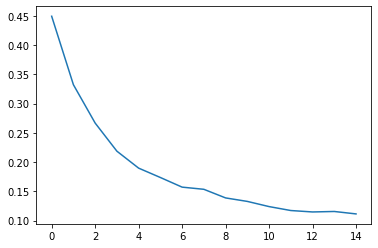

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(DNN.loss_list)), DNN.loss_list)

In [49]:
y_prad = DNN.predict(X_test)
# a = np.argmax(a,axis=1)
y_true = np.argmax(y_test_one_hot,axis=1)
y_true

array([7, 2, 1, ..., 4, 5, 6])

In [50]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_prad)

0.9639